<a href="https://colab.research.google.com/github/ag9602/AIB09_Discussion/blob/master/projact2_%EC%95%88%EA%B1%B4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!pip install category_encoders

In [9]:
!pip install catboost

In [10]:
!pip install eli5

In [11]:
!pip install pdpbox

In [12]:
!pip install shap

In [13]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV
from eli5.sklearn import PermutationImportance
import eli5
from pdpbox.pdp import pdp_isolate, pdp_plot
import shap

In [43]:
train = pd.read_csv('/content/flights.csv')
airlines = pd.read_csv('/content/airlines.csv')

# Cost의 한계로 6만개의 data로 진행
train = train[0:60000]
train

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,2354.0,-11.0,21.0,15.0,205.0,194.0,169.0,1448,404.0,4.0,430,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,2.0,-8.0,12.0,14.0,280.0,279.0,263.0,2330,737.0,4.0,750,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,18.0,-2.0,16.0,34.0,286.0,293.0,266.0,2296,800.0,11.0,806,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,15.0,-5.0,15.0,30.0,285.0,281.0,258.0,2342,748.0,8.0,805,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,24.0,-1.0,11.0,35.0,235.0,215.0,199.0,1448,254.0,5.0,320,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,2015,1,4,7,EV,4350,N12175,IAH,BHM,1918,1946.0,28.0,14.0,2000.0,96.0,100.0,80.0,562,2120.0,6.0,2054,2126.0,32.0,0,0,NaN,4.0,0.0,0.0,28.0,0.0
59996,2015,1,4,7,F9,651,N906FR,BMI,DEN,1918,1958.0,40.0,9.0,2007.0,148.0,148.0,133.0,834,2120.0,6.0,2046,2126.0,40.0,0,0,NaN,6.0,0.0,25.0,9.0,0.0
59997,2015,1,4,7,HA,195,N483HA,OGG,HNL,1918,1919.0,1.0,8.0,1927.0,35.0,38.0,25.0,100,1952.0,5.0,1953,1957.0,4.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
59998,2015,1,4,7,DL,2627,N913DL,RSW,LGA,1919,2139.0,140.0,17.0,2156.0,169.0,157.0,134.0,1080,10.0,6.0,2208,16.0,128.0,0,0,NaN,0.0,0.0,5.0,123.0,0.0


In [44]:
# 결측치 확인
train.isnull().sum()

YEAR                       0
MONTH                      0
DAY                        0
DAY_OF_WEEK                0
AIRLINE                    0
FLIGHT_NUMBER              0
TAIL_NUMBER               63
ORIGIN_AIRPORT             0
DESTINATION_AIRPORT        0
SCHEDULED_DEPARTURE        0
DEPARTURE_TIME          1357
DEPARTURE_DELAY         1357
TAXI_OUT                1385
WHEELS_OFF              1385
SCHEDULED_TIME             0
ELAPSED_TIME            1529
AIR_TIME                1529
DISTANCE                   0
WHEELS_ON               1423
TAXI_IN                 1423
SCHEDULED_ARRIVAL          0
ARRIVAL_TIME            1423
ARRIVAL_DELAY           1529
DIVERTED                   0
CANCELLED                  0
CANCELLATION_REASON    58604
AIR_SYSTEM_DELAY       39299
SECURITY_DELAY         39299
AIRLINE_DELAY          39299
LATE_AIRCRAFT_DELAY    39299
WEATHER_DELAY          39299
dtype: int64

In [45]:
def engineering(df):
    # 도착 지연을 예측해야 하므로 도착정보에 관한 컬럼과 필요없는 컬럼은 제거.
    df = df[['AIRLINE', 'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
        'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT',
        'WHEELS_OFF', 'SCHEDULED_TIME', 'DISTANCE',
        'SCHEDULED_ARRIVAL', 'ARRIVAL_DELAY']]
    # 15분 이상 지연되었다는 것을 표시하는 컬럼을 새로 만든다.
    result=[]

    for row in df['ARRIVAL_DELAY']:
        if row > 15:
            result.append(1)
        else:
            result.append(0)  

    df['result'] = result
    
    # 분류 컬럼을 만들었으니 예측을 위해 기존 컬럼 삭제
    df = df.drop(['ARRIVAL_DELAY'], axis = 1)

    # 결측치 제거
    df = df.dropna()
    return df

train = engineering(train)

In [46]:
train.dtypes

AIRLINE                 object
TAIL_NUMBER             object
ORIGIN_AIRPORT          object
DESTINATION_AIRPORT     object
SCHEDULED_DEPARTURE      int64
DEPARTURE_TIME         float64
DEPARTURE_DELAY        float64
TAXI_OUT               float64
WHEELS_OFF             float64
SCHEDULED_TIME         float64
DISTANCE                 int64
SCHEDULED_ARRIVAL        int64
result                   int64
dtype: object

In [47]:
# object에 대해범주 확인
unicol = ['AIRLINE', 'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT']
for i in unicol:
    print(i, train[i].unique())

AIRLINE ['AS' 'AA' 'US' 'DL' 'NK' 'UA' 'HA' 'B6' 'OO' 'EV' 'F9' 'WN' 'MQ' 'VX']
TAIL_NUMBER ['N407AS' 'N3KUAA' 'N171US' ... 'N33132' 'N363AA' 'N974EV']
ORIGIN_AIRPORT ['ANC' 'LAX' 'SFO' 'SEA' 'LAS' 'DEN' 'SLC' 'PDX' 'FAI' 'MSP' 'PHX' 'SJU'
 'PBG' 'IAG' 'PSE' 'BQN' 'ORD' 'GEG' 'HNL' 'ONT' 'MCO' 'BOS' 'HIB' 'ABR'
 'DFW' 'MKE' 'IAH' 'BNA' 'BRO' 'VPS' 'BOI' 'BJI' 'PHL' 'SBN' 'EUG' 'IAD'
 'BUF' 'PWM' 'JFK' 'CRP' 'PIA' 'FAT' 'SMF' 'AUS' 'MCI' 'ATL' 'JAX' 'MFR'
 'IDA' 'MSN' 'DCA' 'SAT' 'CHS' 'SBA' 'IND' 'CLE' 'GSP' 'BDL' 'RIC' 'BFL'
 'OMA' 'RDM' 'FLL' 'CID' 'TPA' 'SYR' 'ROC' 'TYR' 'LAN' 'GSO' 'EWR' 'PBI'
 'RSW' 'OAK' 'PVD' 'RNO' 'PIT' 'ABQ' 'MIA' 'BWI' 'TUL' 'LGA' 'LIT' 'MSY'
 'OKC' 'ATW' 'PNS' 'MEM' 'TYS' 'MHT' 'SAV' 'CLT' 'GRB' 'ABE' 'JAN' 'OAJ'
 'FAR' 'ERI' 'LEX' 'CWA' 'TTN' 'RDU' 'CVG' 'BHM' 'ACY' 'DTW' 'RAP' 'TUS'
 'EAU' 'DLH' 'FSD' 'INL' 'SPI' 'CLD' 'COD' 'CMH' 'PSC' 'CPR' 'ACV' 'DAL'
 'PAH' 'MRY' 'ESC' 'ISN' 'PSP' 'CAE' 'STL' 'BTV' 'MTJ' 'GCC' 'OGG' 'SJC'
 'GUC' 'ORF' 'MOT' 'MLU' 'KOA'

In [48]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
SCHEDULED_DEPARTURE,58615.0,1316.239307,465.667907,5.0,927.0,1316.0,1710.0,2359.0
DEPARTURE_TIME,58615.0,1336.385550,485.656053,1.0,934.0,1333.0,1732.0,2400.0
DEPARTURE_DELAY,58615.0,18.969752,45.056959,-39.0,-3.0,3.0,24.0,1380.0
TAXI_OUT,58615.0,16.792152,9.867406,1.0,11.0,14.0,19.0,176.0
WHEELS_OFF,58615.0,1359.748716,486.459993,1.0,948.0,1347.0,1746.0,2400.0
SCHEDULED_TIME,58615.0,145.460411,76.997739,23.0,88.0,128.0,180.0,718.0
DISTANCE,58615.0,852.093287,614.983299,31.0,399.0,692.0,1091.0,4983.0
SCHEDULED_ARRIVAL,58615.0,1498.930461,484.425954,1.0,1124.0,1520.0,1905.0,2359.0
result,58615.0,0.342182,0.474444,0.0,0.0,0.0,1.0,1.0


0    0.657818
1    0.342182
Name: result, dtype: float64


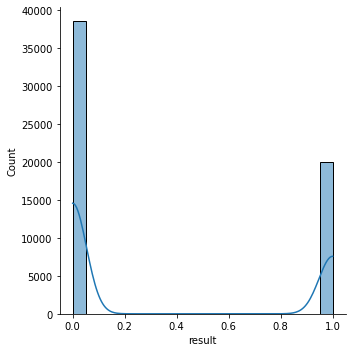

In [49]:
# 분포확인
print(train['result'].value_counts(normalize=True))
sns.displot(train['result'],kde=True);

In [50]:
ratio = 0.342182 / 0.657818
ratio

0.5201773134818445

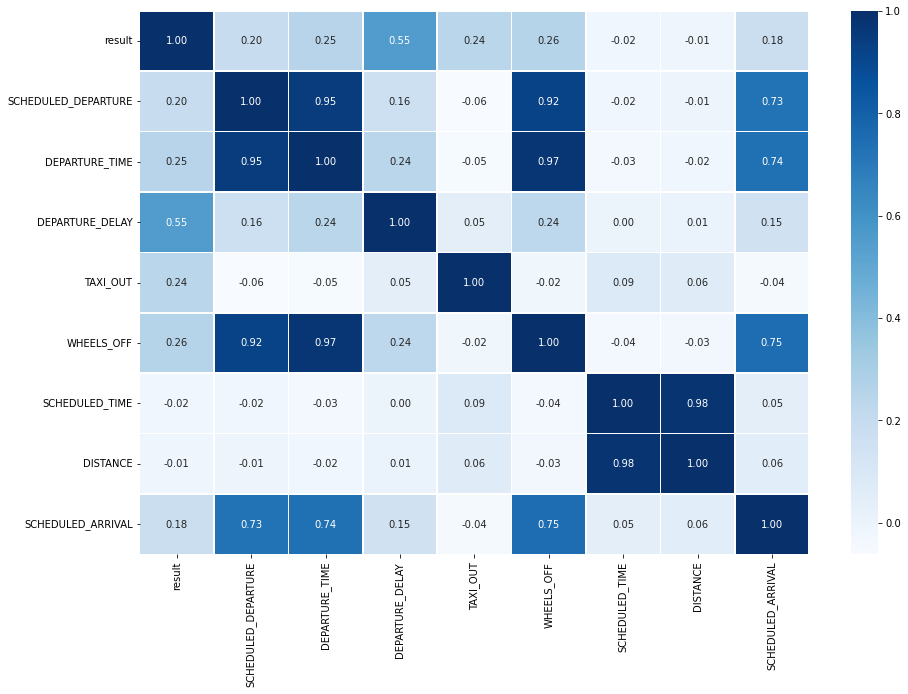

In [51]:
# 상관관계 시각화
new = train['result']
train = train.drop(['result'], axis = 1)
train = pd.concat([new, train], axis = 1)
plt.figure(figsize = (15,10))
sns.heatmap(data = train.corr(), annot=True, fmt = '.2f', linewidths=.5, cmap='Blues');

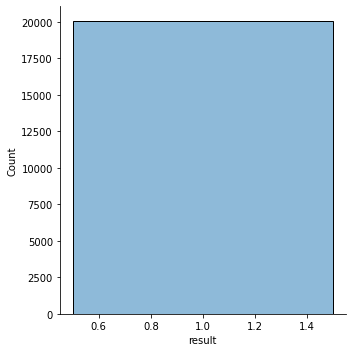

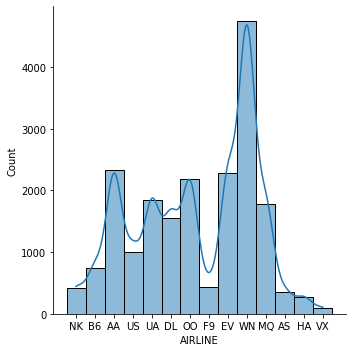

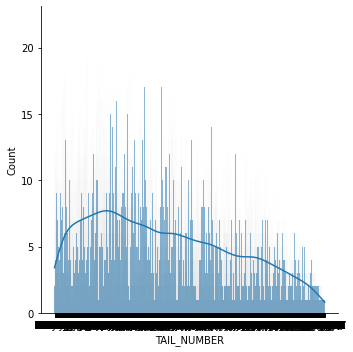

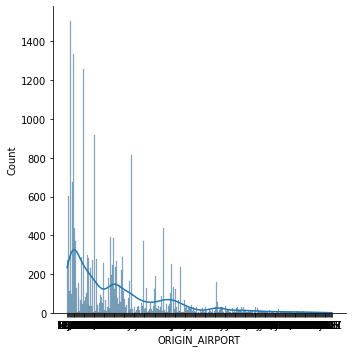

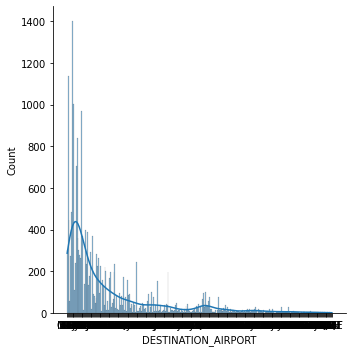

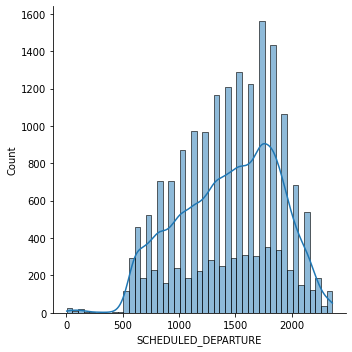

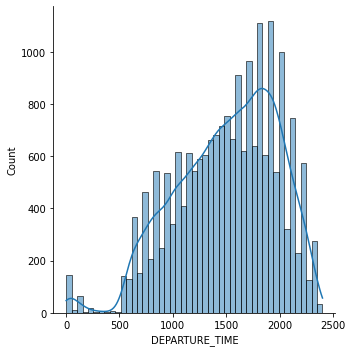

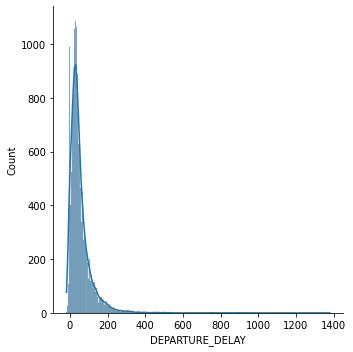

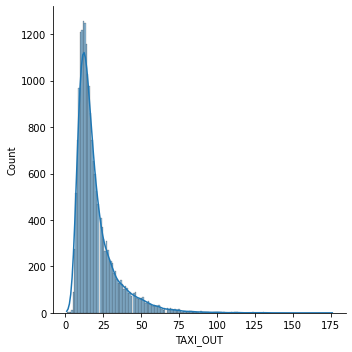

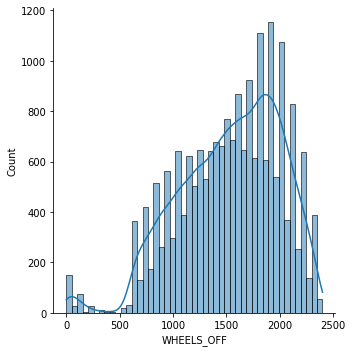

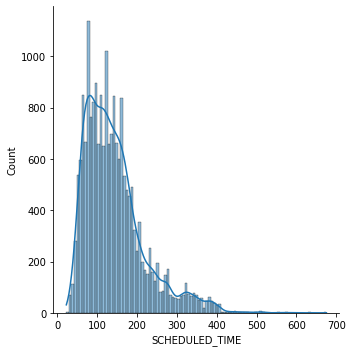

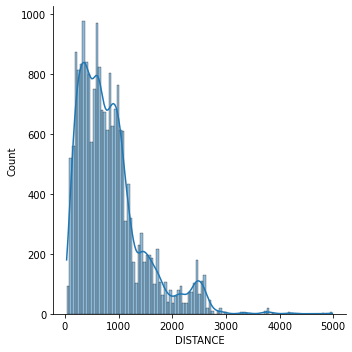

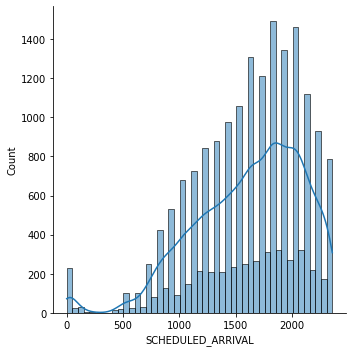

In [52]:
# 특성별 분포확인
delay = train[train.result == 1]
delay.shape
dp = train.columns
for i in dp:
    sns.displot(delay[i],kde=True);

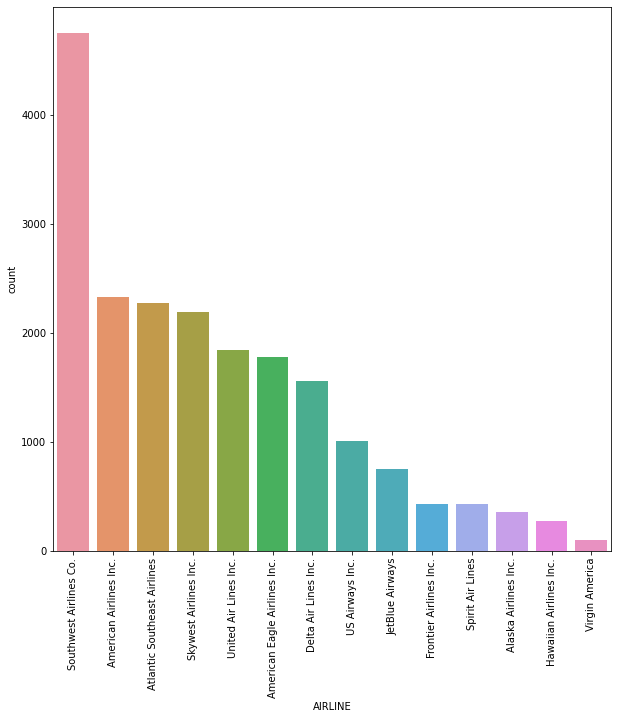

In [53]:
# 지연 상황만 가정
delay = train[train.result == 1]
delay.shape

a_del = delay['AIRLINE'].value_counts().reset_index().rename(columns={'index':'IATA_CODE', 'AIRLINE':'count'})
a_del = pd.merge(a_del, airlines, how='left', on='IATA_CODE')

plt.figure(figsize=(10,10))
sns.barplot(x = 'AIRLINE', y = 'count', data = a_del)
plt.xticks(rotation=90)
plt.show()

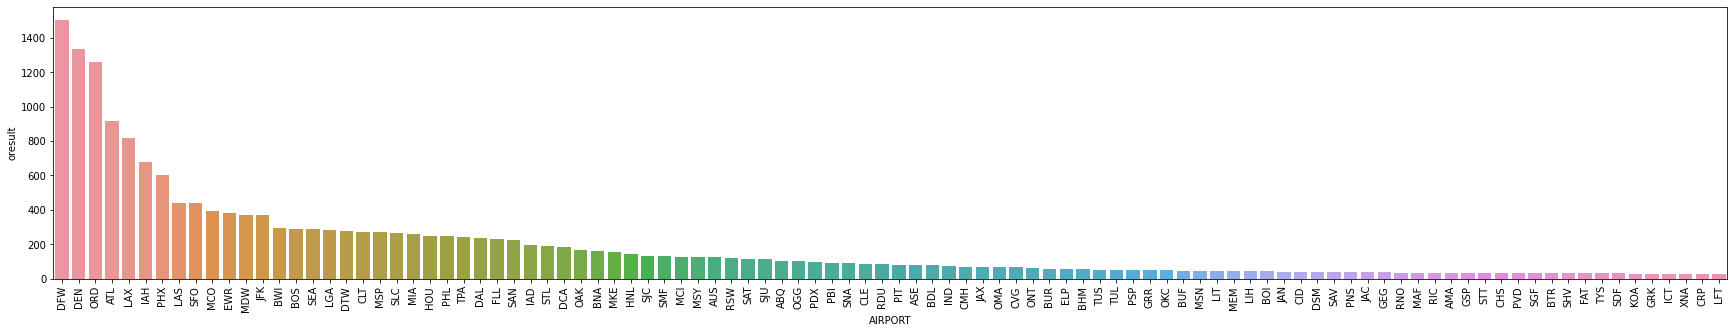

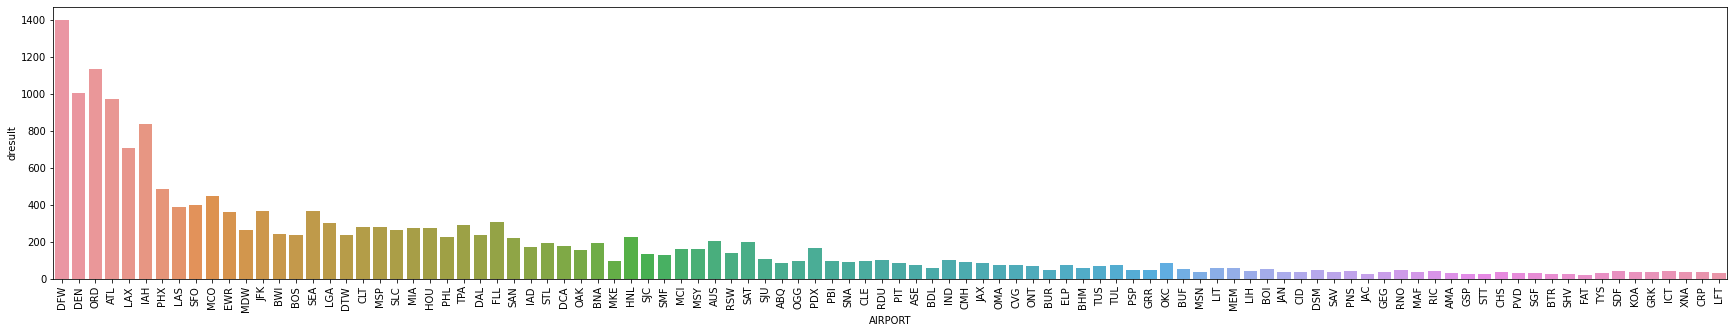

In [54]:
oa_del = delay['ORIGIN_AIRPORT'].value_counts().reset_index().rename(columns={'index':'AIRPORT', 'ORIGIN_AIRPORT':'oresult'})
da_del = delay['DESTINATION_AIRPORT'].value_counts().reset_index().rename(columns={'index':'AIRPORT', 'DESTINATION_AIRPORT':'dresult'})
oda_del = pd.merge(oa_del, da_del, how='left', on='AIRPORT')
oda_del = oda_del[:100]

for col in oda_del.columns[1:]:
    plt.figure(figsize=(30,5))
    sns.barplot(x = 'AIRPORT', y = col, data = oda_del)
    plt.xticks(rotation=90)
    plt.show()

In [55]:
# 높은 cardinality를 가진 column에 유용한 Ordinal 인코딩 진행
encoder = OrdinalEncoder()
train = encoder.fit_transform(train)

# 학습/검증/테스트 타겟 생성 및 분리
target = 'result'
train, test = train_test_split(train, test_size=0.20, stratify=train[target], random_state=2)
train, val = train_test_split(train, test_size=0.20, stratify=train[target], random_state=2)

# 타겟 지정
features = train.drop(columns=[target]).columns

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

X_train.shape, X_val.shape, X_test.shape

((37513, 12), (9379, 12), (11723, 12))

In [56]:
# 1차 Modeling : RandomForest
model = RandomForestClassifier(n_jobs=-1, random_state=2)

model.fit(X_train, y_train)
y_pred = model.predict(X_val)
print('훈련 정확도', model.score(X_train, y_train))
print('검증 정확도', model.score(X_val, y_val))
print('Report \n',classification_report(y_val, y_pred))
print('f1 스코어',f1_score(y_val, y_pred))
print('auc점수 : ', roc_auc_score(y_val, y_pred))

훈련 정확도 0.9999733425745742
검증 정확도 0.9037210790062906
Report 
               precision    recall  f1-score   support

           0       0.91      0.95      0.93      6170
           1       0.89      0.82      0.85      3209

    accuracy                           0.90      9379
   macro avg       0.90      0.88      0.89      9379
weighted avg       0.90      0.90      0.90      9379

f1 스코어 0.852859703438162
auc점수 :  0.8825568334197832


In [57]:
# 2차 Modeling : CatBoostClassfier
model = CatBoostClassifier()

model.fit(X_train, y_train)
y_pred = model.predict(X_val)
print('훈련 정확도', model.score(X_train, y_train))
print('검증 정확도', model.score(X_val, y_val))
print('Report \n',classification_report(y_val, y_pred))
print('f1 스코어',f1_score(y_val, y_pred))
print('auc점수 : ', roc_auc_score(y_val, y_pred))

Learning rate set to 0.048429
0:	learn: 0.6394211	total: 16.7ms	remaining: 16.6s
1:	learn: 0.5928915	total: 30ms	remaining: 15s
2:	learn: 0.5508044	total: 43.5ms	remaining: 14.5s
3:	learn: 0.5108415	total: 56.5ms	remaining: 14.1s
4:	learn: 0.4812358	total: 73ms	remaining: 14.5s
5:	learn: 0.4544561	total: 85.5ms	remaining: 14.2s
6:	learn: 0.4303670	total: 97.3ms	remaining: 13.8s
7:	learn: 0.4085602	total: 109ms	remaining: 13.6s
8:	learn: 0.3942203	total: 121ms	remaining: 13.3s
9:	learn: 0.3765991	total: 133ms	remaining: 13.1s
10:	learn: 0.3608069	total: 144ms	remaining: 13s
11:	learn: 0.3488453	total: 156ms	remaining: 12.8s
12:	learn: 0.3377486	total: 172ms	remaining: 13.1s
13:	learn: 0.3265468	total: 188ms	remaining: 13.2s
14:	learn: 0.3178702	total: 207ms	remaining: 13.6s
15:	learn: 0.3095843	total: 219ms	remaining: 13.5s
16:	learn: 0.3019960	total: 231ms	remaining: 13.4s
17:	learn: 0.2960493	total: 243ms	remaining: 13.3s
18:	learn: 0.2906018	total: 254ms	remaining: 13.1s
19:	learn: 0

idx: 550 , threshold: 0.33264954158420934
Report 
               precision    recall  f1-score   support

           0       0.94      0.92      0.93      6170
           1       0.86      0.88      0.87      3209

    accuracy                           0.91      9379
   macro avg       0.90      0.90      0.90      9379
weighted avg       0.91      0.91      0.91      9379

최종 검증 정확도:  0.9102249706791768
최종 f1 스코어 0.8707002457002458
최종 auc점수 :  0.9038009488104011


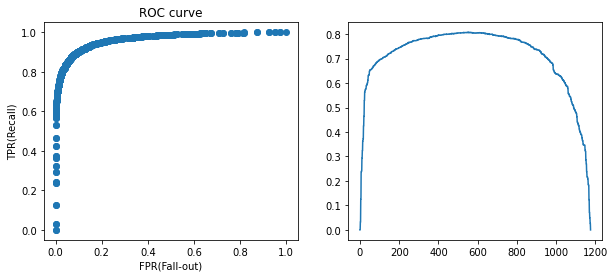

In [58]:
# roc_curve(타겟값, prob of 1)
y_pred_proba = model.predict_proba(X_val)[:, 1]
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

roc = pd.DataFrame({
    'FPR(Fall-out)': fpr, 
    'TPRate(Recall)': tpr, 
    'Threshold': thresholds
})
# print(roc)

# roc 시각화
plt.rcParams["figure.figsize"] = (10,4)
plt.subplot(121)
plt.scatter(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('FPR(Fall-out)')
plt.ylabel('TPR(Recall)');

# 최적의 threshold
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print('idx:', optimal_idx, ', threshold:', optimal_threshold)

# auc 시각화
plt.subplot(122)
plt.plot(tpr-fpr);

# threshold 설정 및 레포트
y_pred_optimal = y_pred_proba >= optimal_threshold
print('Report \n',classification_report(y_val, y_pred_optimal))

# auc 점수
auc_score = roc_auc_score(y_val, y_pred_optimal)
print('최종 검증 정확도: ', accuracy_score(y_val, y_pred_optimal))
print('최종 f1 스코어',f1_score(y_val, y_pred_optimal))
print('최종 auc점수 : ', auc_score)

0:	learn: 0.5679397	total: 59.1ms	remaining: 11.8s
1:	learn: 0.4706952	total: 109ms	remaining: 10.7s
2:	learn: 0.4013837	total: 162ms	remaining: 10.7s
3:	learn: 0.3438803	total: 214ms	remaining: 10.5s
4:	learn: 0.3047745	total: 268ms	remaining: 10.5s
5:	learn: 0.2798135	total: 324ms	remaining: 10.5s
6:	learn: 0.2598847	total: 377ms	remaining: 10.4s
7:	learn: 0.2429656	total: 437ms	remaining: 10.5s
8:	learn: 0.2292154	total: 506ms	remaining: 10.7s
9:	learn: 0.2179314	total: 561ms	remaining: 10.7s
10:	learn: 0.2100362	total: 613ms	remaining: 10.5s
11:	learn: 0.2033195	total: 670ms	remaining: 10.5s
12:	learn: 0.1971689	total: 730ms	remaining: 10.5s
13:	learn: 0.1934776	total: 788ms	remaining: 10.5s
14:	learn: 0.1903606	total: 849ms	remaining: 10.5s
15:	learn: 0.1872658	total: 915ms	remaining: 10.5s
16:	learn: 0.1842871	total: 976ms	remaining: 10.5s
17:	learn: 0.1814707	total: 1.03s	remaining: 10.4s
18:	learn: 0.1794643	total: 1.08s	remaining: 10.3s
19:	learn: 0.1774461	total: 1.14s	remain

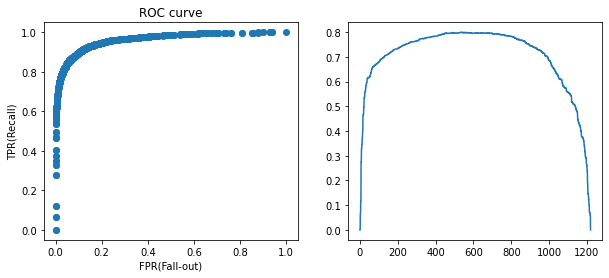

In [59]:
model = CatBoostClassifier(scale_pos_weight = ratio, learning_rate = 0.1, max_depth = 10, n_estimators = 200)

model.fit(X_train, y_train)
y_pred = model.predict(X_val)

# roc_curve(타겟값, prob of 1)
y_pred_proba = model.predict_proba(X_val)[:, 1]
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

roc = pd.DataFrame({
    'FPR(Fall-out)': fpr, 
    'TPRate(Recall)': tpr, 
    'Threshold': thresholds
})
# print(roc)

# roc 시각화
plt.rcParams["figure.figsize"] = (10,4)
plt.subplot(121)
plt.scatter(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('FPR(Fall-out)')
plt.ylabel('TPR(Recall)');

# 최적의 threshold
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print('idx:', optimal_idx, ', threshold:', optimal_threshold)

# auc 시각화
plt.subplot(122)
plt.plot(tpr-fpr);

# threshold 설정 및 레포트
y_pred_optimal = y_pred_proba >= optimal_threshold
print('Report \n',classification_report(y_val, y_pred_optimal))

# auc 점수
auc_score = roc_auc_score(y_val, y_pred_optimal)
print('최종 검증 정확도: ', accuracy_score(y_val, y_pred_optimal))
print('최종 f1 스코어',f1_score(y_val, y_pred_optimal))
print('최종 auc점수 : ', auc_score)

0:	learn: 0.5709168	total: 36.7ms	remaining: 11s
1:	learn: 0.4733906	total: 68.7ms	remaining: 10.2s
2:	learn: 0.3975393	total: 105ms	remaining: 10.4s
3:	learn: 0.3467248	total: 142ms	remaining: 10.5s
4:	learn: 0.3109409	total: 176ms	remaining: 10.4s
5:	learn: 0.2847809	total: 208ms	remaining: 10.2s
6:	learn: 0.2611403	total: 243ms	remaining: 10.2s
7:	learn: 0.2460969	total: 282ms	remaining: 10.3s
8:	learn: 0.2323056	total: 313ms	remaining: 10.1s
9:	learn: 0.2216700	total: 346ms	remaining: 10s
10:	learn: 0.2139735	total: 381ms	remaining: 10s
11:	learn: 0.2069630	total: 413ms	remaining: 9.91s
12:	learn: 0.2015194	total: 447ms	remaining: 9.86s
13:	learn: 0.1963235	total: 484ms	remaining: 9.88s
14:	learn: 0.1932501	total: 515ms	remaining: 9.79s
15:	learn: 0.1911895	total: 551ms	remaining: 9.78s
16:	learn: 0.1879342	total: 583ms	remaining: 9.71s
17:	learn: 0.1857358	total: 616ms	remaining: 9.66s
18:	learn: 0.1835730	total: 657ms	remaining: 9.71s
19:	learn: 0.1817568	total: 689ms	remaining: 

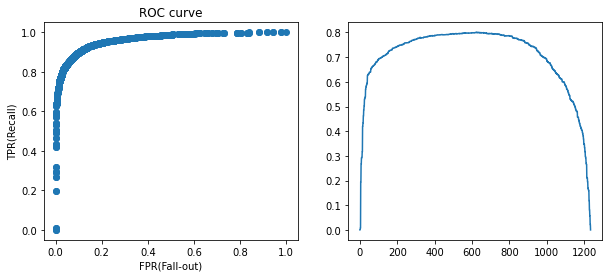

In [61]:
params ={
    'n_estimators': [100, 200, 300],
    'max_depth':[9],
    'learning_rate':[0.1, 0.2, 0.3]
}

cb = CatBoostClassifier(scale_pos_weight = ratio)
grid_cv = GridSearchCV(cb, param_grid=params, n_jobs=-1)
grid_cv.fit(X_train, y_train)
print('best parameters : \n', grid_cv.best_params_)


# Best parameters 적용 Modeling
model = CatBoostClassifier(scale_pos_weight = ratio, learning_rate = 0.1, max_depth = 9, n_estimators = 200)

model.fit(X_train, y_train)
y_pred = model.predict(X_val)

# roc_curve(타겟값, prob of 1)
y_pred_proba = model.predict_proba(X_val)[:, 1]
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

roc = pd.DataFrame({
    'FPR(Fall-out)': fpr, 
    'TPRate(Recall)': tpr, 
    'Threshold': thresholds
})
# print(roc)

# roc 시각화
plt.rcParams["figure.figsize"] = (10,4)
plt.subplot(121)
plt.scatter(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('FPR(Fall-out)')
plt.ylabel('TPR(Recall)');

# 최적의 threshold
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print('idx:', optimal_idx, ', threshold:', optimal_threshold)

# auc 시각화
plt.subplot(122)
plt.plot(tpr-fpr);

# threshold 설정 및 레포트
y_pred_optimal = y_pred_proba >= optimal_threshold
print('Report \n',classification_report(y_val, y_pred_optimal))

# auc 점수
auc_score = roc_auc_score(y_val, y_pred_optimal)
print('최종 검증 정확도: ', accuracy_score(y_val, y_pred_optimal))
print('최종 f1 스코어',f1_score(y_val, y_pred_optimal))
print('최종 auc점수 : ', auc_score)

0:	learn: 0.5679397	total: 71.7ms	remaining: 21.4s
1:	learn: 0.4706952	total: 127ms	remaining: 18.9s
2:	learn: 0.4013837	total: 187ms	remaining: 18.5s
3:	learn: 0.3438803	total: 244ms	remaining: 18.1s
4:	learn: 0.3047745	total: 313ms	remaining: 18.5s
5:	learn: 0.2798135	total: 369ms	remaining: 18.1s
6:	learn: 0.2598847	total: 421ms	remaining: 17.6s
7:	learn: 0.2429656	total: 479ms	remaining: 17.5s
8:	learn: 0.2292154	total: 540ms	remaining: 17.5s
9:	learn: 0.2179314	total: 616ms	remaining: 17.9s
10:	learn: 0.2100362	total: 672ms	remaining: 17.7s
11:	learn: 0.2033195	total: 734ms	remaining: 17.6s
12:	learn: 0.1971689	total: 798ms	remaining: 17.6s
13:	learn: 0.1934776	total: 858ms	remaining: 17.5s
14:	learn: 0.1903606	total: 911ms	remaining: 17.3s
15:	learn: 0.1872658	total: 971ms	remaining: 17.2s
16:	learn: 0.1842871	total: 1.03s	remaining: 17.1s
17:	learn: 0.1814707	total: 1.09s	remaining: 17.1s
18:	learn: 0.1794643	total: 1.14s	remaining: 16.9s
19:	learn: 0.1774461	total: 1.2s	remaini

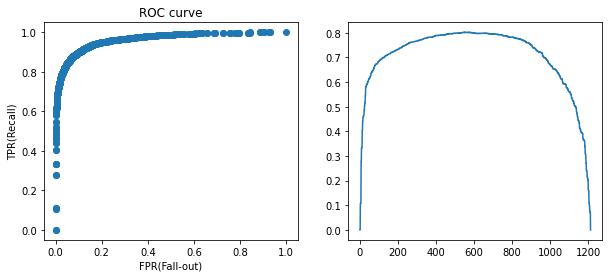

In [62]:
model = CatBoostClassifier(scale_pos_weight = ratio, learning_rate = 0.1, max_depth = 10, n_estimators = 300)

model.fit(X_train, y_train)
y_pred = model.predict(X_val)

# roc_curve(타겟값, prob of 1)
y_pred_proba = model.predict_proba(X_val)[:, 1]
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

roc = pd.DataFrame({
    'FPR(Fall-out)': fpr, 
    'TPRate(Recall)': tpr, 
    'Threshold': thresholds
})
# print(roc)

# roc 시각화
plt.rcParams["figure.figsize"] = (10,4)
plt.subplot(121)
plt.scatter(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('FPR(Fall-out)')
plt.ylabel('TPR(Recall)');

# 최적의 threshold
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print('idx:', optimal_idx, ', threshold:', optimal_threshold)

# auc 시각화
plt.subplot(122)
plt.plot(tpr-fpr);

# threshold 설정 및 레포트
y_pred_optimal = y_pred_proba >= optimal_threshold
print('Report \n',classification_report(y_val, y_pred_optimal))

# auc 점수
auc_score = roc_auc_score(y_val, y_pred_optimal)
print('최종 검증 정확도: ', accuracy_score(y_val, y_pred_optimal))
print('최종 f1 스코어',f1_score(y_val, y_pred_optimal))
print('최종 auc점수 : ', auc_score)

idx: 770 , threshold: 0.16467949924399014
Report 
               precision    recall  f1-score   support

           0       0.95      0.90      0.92      7712
           1       0.82      0.90      0.86      4011

    accuracy                           0.90     11723
   macro avg       0.88      0.90      0.89     11723
weighted avg       0.90      0.90      0.90     11723

테스트 정확도 0.9121385310927237
f1 스코어 0.8611144113104431
auc점수 :  0.9010574589484726


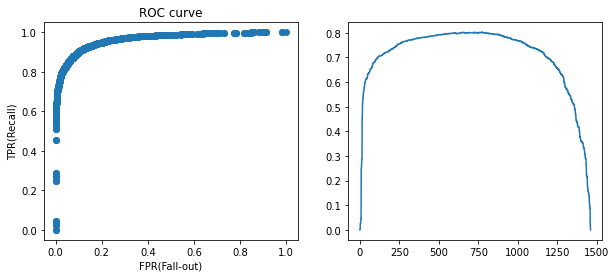

In [63]:
# 테스트 데이터 성능확인
y_pred = model.predict(X_test)

# roc_curve(타겟값, prob of 1)
y_pred_proba = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

roc = pd.DataFrame({
    'FPR(Fall-out)': fpr, 
    'TPRate(Recall)': tpr, 
    'Threshold': thresholds
})

# roc 시각화
plt.rcParams["figure.figsize"] = (10,4)
plt.subplot(121)
plt.scatter(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('FPR(Fall-out)')
plt.ylabel('TPR(Recall)');

# 최적의 threshold
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print('idx:', optimal_idx, ', threshold:', optimal_threshold)

# auc 시각화
plt.subplot(122)
plt.plot(tpr-fpr);

# threshold 설정 및 레포트
y_pred_optimal = y_pred_proba >= optimal_threshold
print('Report \n',classification_report(y_test, y_pred_optimal))

# auc 점수
auc_score = roc_auc_score(y_test, y_pred_optimal)
print('테스트 정확도', model.score(X_test, y_test))
print('f1 스코어',f1_score(y_test, y_pred_optimal))
print('auc점수 : ', auc_score)